In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.ticker import FuncFormatter


In [ ]:
data_path = '../data'

In [ ]:
# Load dataset
df = pd.read_csv(data_path + "/vgchartz-2024.csv")

# Display the first few rows of the dataset
print(df.head())

# Display the dimensions of the dataset
print(df.shape)


                                             img                        title  \
0  /games/boxart/full_6510540AmericaFrontccc.jpg           Grand Theft Auto V   
1  /games/boxart/full_5563178AmericaFrontccc.jpg           Grand Theft Auto V   
2                    /games/boxart/827563ccc.jpg  Grand Theft Auto: Vice City   
3  /games/boxart/full_9218923AmericaFrontccc.jpg           Grand Theft Auto V   
4  /games/boxart/full_4990510AmericaFrontccc.jpg    Call of Duty: Black Ops 3   

  console    genre       publisher       developer  critic_score  total_sales  \
0     PS3   Action  Rockstar Games  Rockstar North           9.4        20.32   
1     PS4   Action  Rockstar Games  Rockstar North           9.7        19.39   
2     PS2   Action  Rockstar Games  Rockstar North           9.6        16.15   
3    X360   Action  Rockstar Games  Rockstar North           NaN        15.86   
4     PS4  Shooter      Activision        Treyarch           8.1        15.09   

   na_sales  jp_sales  pal

In [3]:
# Drop columns that are not needed for analysis
columns_to_drop = ['img', 'last_update']
df.drop(columns=columns_to_drop, inplace=True)

# Print remaining column names
print(df.columns)

Index(['title', 'console', 'genre', 'publisher', 'developer', 'critic_score',
       'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales',
       'release_date'],
      dtype='object')


In [4]:
# Check for missing values in the dataset
print(df.isnull().sum())

title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
dtype: int64


In [5]:
# Fill missing numeric fields
numeric_cols = ["na_sales", "jp_sales", "pal_sales", "other_sales"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col]).fillna(0)

# If total_sales missing, compute from regional sales
df["total_sales"] = pd.to_numeric(df["total_sales"])
df["total_sales"] = df["total_sales"].fillna(df[numeric_cols].sum(axis=1))

In [6]:
# Fill missing critic_score with genre average
'''
df["critic_score"] = pd.to_numeric(df["critic_score"], errors='coerce')
df["critic_score"] = df.groupby("genre")["critic_score"].transform(
    lambda x: x.fillna(x.mean())
)
'''

'\ndf["critic_score"] = pd.to_numeric(df["critic_score"], errors=\'coerce\')\ndf["critic_score"] = df.groupby("genre")["critic_score"].transform(\n    lambda x: x.fillna(x.mean())\n)\n'

In [7]:
# Convert release_date to datetime and drop rows with invalid/missing dates
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df = df.dropna(subset=["release_date"])

In [8]:
# Normalize text fields
'''
for col in ["title", "console", "genre", "publisher", "developer"]:
    df[col] = df[col].astype(str).str.strip().str.title()
'''

'\nfor col in ["title", "console", "genre", "publisher", "developer"]:\n    df[col] = df[col].astype(str).str.strip().str.title()\n'

In [9]:
# Remove duplicates
df = df.drop_duplicates()

In [ ]:
# Save the cleaned dataset to a new CSV file

df.to_csv(data_path + "/vgchartz_cleaned.csv", index=False)

How have global video game sales evolved across platforms over time?

In [11]:
df["year"] = df["release_date"].dt.year
df = df[df["year"].between(1980, 2020)]

# Aggregate total sales per year per platform
sales_trend = df.groupby(["year", "console"], as_index=False)["total_sales"].sum()

# Sort by year for plotting
sales_trend = sales_trend.sort_values("year")

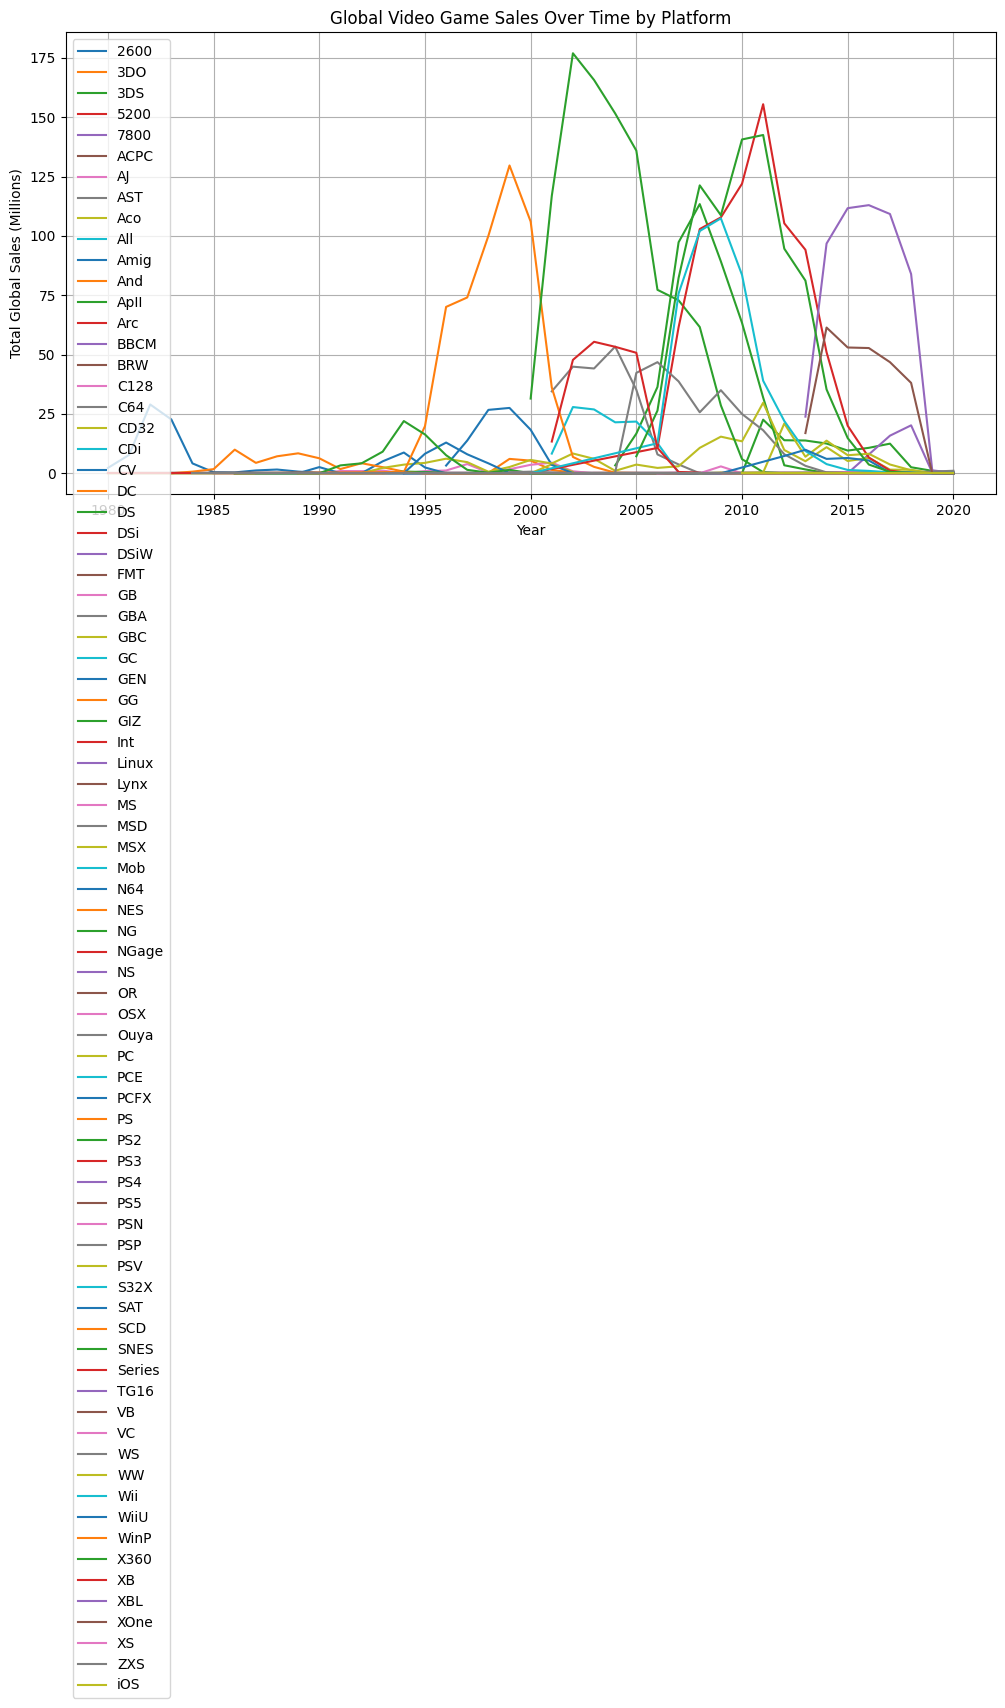

In [12]:
plt.figure(figsize=(12, 6))
for platform, data in sales_trend.groupby("console"):
    plt.plot(data["year"], data["total_sales"], label=platform)

plt.title("Global Video Game Sales Over Time by Platform")
plt.xlabel("Year")
plt.ylabel("Total Global Sales (Millions)")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Print names of all unique platforms
print(df["console"].unique())

['PS3' 'PS4' 'PS2' 'X360' 'XOne' 'PC' 'PSP' 'Wii' 'PS' 'DS' '2600' 'GBA'
 'NES' 'XB' 'PSN' 'GEN' 'PSV' 'DC' 'N64' 'SAT' 'SNES' 'GBC' 'GC' 'NS'
 '3DS' 'GB' 'WiiU' 'WS' 'VC' 'NG' 'WW' 'SCD' 'PCE' 'XBL' '3DO' 'GG' 'OSX'
 'Mob' 'PCFX' 'Series' 'All' 'iOS' '5200' 'And' 'DSiW' 'Lynx' 'Linux' 'MS'
 'ZXS' 'ACPC' 'Amig' '7800' 'AJ' 'WinP' 'VB' 'Ouya' 'NGage' 'AST' 'MSD'
 'S32X' 'Int' 'PS5' 'XS' 'CV' 'OR' 'C128' 'CDi' 'DSi' 'Arc' 'C64' 'BRW'
 'FMT' 'MSX' 'GIZ' 'ApII' 'Aco' 'BBCM' 'TG16' 'CD32']


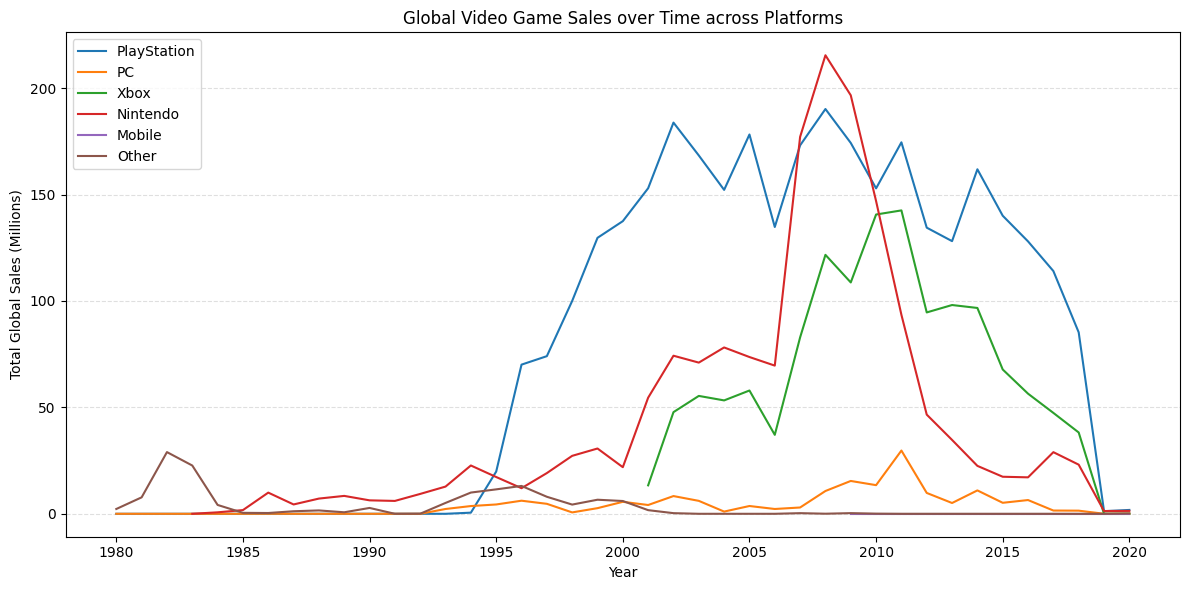

In [29]:
def platform_group(name):
    if name in ("Wii","WiiU", "NS","NES","SNES","N64","GC","GBC","GB","GBA","DS","3DS", "DSi", "DSiW"):
        return "Nintendo"
    elif name.startswith(("X360", "XOne", "XS", "XB")):
        return "Xbox"
    elif name.startswith(("PS")) or name in ("Series"):
        return "PlayStation"
    elif name in ("PC", "Linux") or name.startswith("Win"):
        return "PC"
    elif name in ("iOS", "And"):
        return "Mobile"
    else:
        return "Other"

df["platform_family"] = df["console"].apply(platform_group)

family_trend = df.groupby(["year", "platform_family"])["total_sales"].sum().reset_index()

order = ["PlayStation","PC","Xbox","Nintendo","Mobile","Other"]

family_included = [g for g in order if g in family_trend["platform_family"].unique()]

plt.figure(figsize=(12, 6))

for family in family_included:
    data = family_trend[family_trend["platform_family"] == family].sort_values("year")
    plt.plot(data["year"], data["total_sales"], label=family)

plt.title("Global Video Game Sales over Time across Platforms")
plt.xlabel("Year")
plt.ylabel("Total Global Sales (Millions)")
plt.legend(loc="upper left")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



/var/folders/v9/3cnw93fs3wn9w2b3fbnm4x0h0000gn/T/ipykernel_20607/1484970700.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_sales, x="genre", y="total_sales", palette=palette)


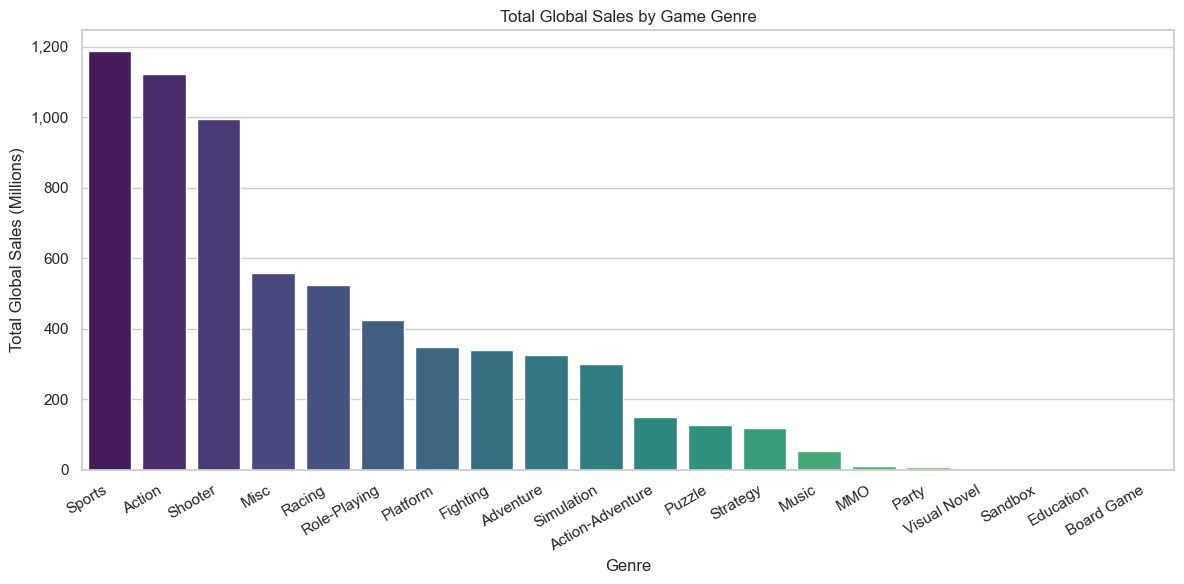

In [36]:
# Aggregate and sort total sales by genre
genre_sales = (
    df.assign(genre=df["genre"].fillna("Unknown"))
      .groupby("genre", as_index=False)["total_sales"]
      .sum()
      .sort_values("total_sales", ascending=False)
)

# Bar chart
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
palette = sns.color_palette("viridis", n_colors=len(genre_sales))
sns.barplot(data=genre_sales, x="genre", y="total_sales", palette=palette)

plt.title("Total Global Sales by Game Genre")
plt.xlabel("Genre")
plt.ylabel("Total Global Sales (Millions)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:,.0f}"))  # readable ticks
plt.ylim(bottom=0)  # proportional scaling from zero
plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()

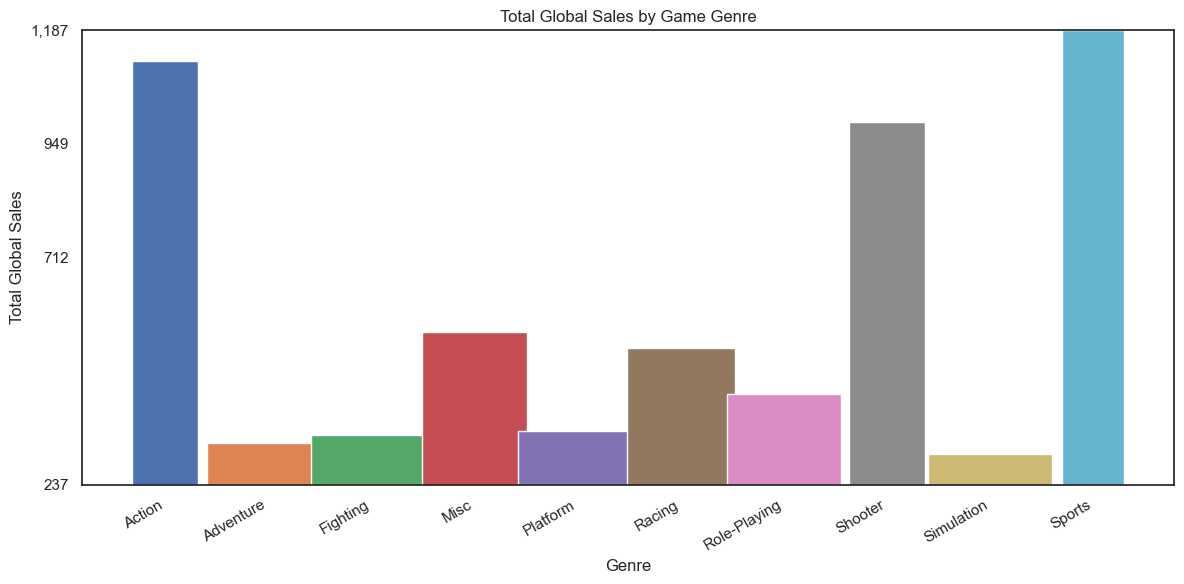

In [50]:
top_n = 10
top_genres = genre_sales.nlargest(top_n, "total_sales")

# Misleading example (for critique): variable bar widths + uneven y-ticks
tmp = top_genres.sort_values("genre").reset_index(drop=True)
x = np.arange(len(tmp))
y = tmp["total_sales"].to_numpy()

# Make smaller values wider (area suggests importance)
w = 0.6 + 0.8 * (y.max() - y) / y.max()

std_palette = sns.color_palette("deep", n_colors=len(tmp))

sns.set_theme(style="white")
plt.figure(figsize=(12, 6))
plt.bar(x, y, width=w, color=std_palette)
'''
sns.barplot(
    data=genre_sales.sort_values("genre"),  # unsorted by sales
    x="genre", y="total_sales",
    palette=sns.color_palette("mako", n_colors=len(genre_sales))
)
'''

max_v = genre_sales["total_sales"].max()
plt.ylim(max_v * 0.2, max_v)  # truncate baseline to exaggerate differences

# Uneven y-tick intervals (distorts perceived gaps)
ymax = y.max()
plt.yticks([ymax*0.2, ymax*0.6, ymax*0.8, ymax], [f"{ymax*0.2:,.0f}", f"{ymax*0.6:,.0f}", f"{ymax*0.8:,.0f}", f"{ymax:,.0f}"])

plt.title("Total Global Sales by Game Genre")
plt.xlabel("Genre")
plt.ylabel("Total Global Sales")
plt.xticks(x, tmp["genre"], rotation=30, ha="right")
plt.grid(False)
plt.tight_layout()
plt.show()